# Imports


In [18]:
import pandas as pd 
import numpy as np 

import datetime as dt

import matplotlib.pyplot as plt
import seaborn as sns

# Helper Functions

In [40]:
#  parse the date
def get_day(x): return dt.datetime(x.year, x.month, x.day) 

def get_month(x): return dt.datetime(x.year, x.month, 1)


def get_date_int(df, column):
    year = df[column].dt.year
    month = df[column].dt.month
    day = df[column].dt.day
    return year, month, day



# 

In [21]:
online_raw = pd.read_csv("../KPIs_and_Exploratory/data/online.csv", parse_dates=['InvoiceDate'])
online_raw.head()

,Unnamed: 0,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,416792,572558,22745,POPPY'S PLAYHOUSE BEDROOM,6,2011-10-25 08:26:00,2.10,14286,United Kingdom
1,482904,577485,23196,VINTAGE LEAF MAGNETIC NOTEPAD,1,2011-11-20 11:56:00,1.45,16360,United Kingdom
2,263743,560034,23299,FOOD COVER WITH BEADS SET 2,6,2011-07-14 13:35:00,3.75,13933,United Kingdom
3,495549,578307,72349B,SET/6 PURPLE BUTTERFLY T-LIGHTS,1,2011-11-23 15:53:00,2.10,17290,United Kingdom
4,204384,554656,21756,BATH BUILDING BLOCK WORD,3,2011-05-25 13:36:00,5.95,17663,United Kingdom


In [25]:
online = online_raw.copy()

# Create InvoiceDay column
online['InvoiceDay'] = online['InvoiceDate'].apply(get_day) 

# Group by CustomerID and select the InvoiceDay value
grouping = online.groupby('CustomerID')['InvoiceDay'] 

# Assign a minimum InvoiceDay value to the dataset
online['CohortDay'] = grouping.transform('min')



In [34]:
# Get the integers for date parts from the `InvoiceDay` column
invoice_year, invoice_month, invoice_day = get_date_int(online, 'InvoiceDay')

# Get the integers for date parts from the `CohortDay` column
cohort_year, cohort_month, cohort_day = get_date_int(online, 'CohortDay')

In [41]:
#monthly
online['InvoiceMonth'] = online['InvoiceDate'].apply(get_month)

#group by customerID
grouping = online.groupby('CustomerID')['InvoiceMonth']

online['CohortMonth'] = grouping.transform('min')

In [42]:
# Calculate difference in years
years_diff = invoice_year - cohort_year

# Calculate difference in months
months_diff = invoice_month - cohort_month

# Calculate difference in days
days_diff = invoice_day - cohort_day


# Extract the difference in days from all previous values
online['CohortIndex_days'] = years_diff * 365 + months_diff * 30 + days_diff + 1

online['CohortIndex_months'] = years_diff * 12 + months_diff + 1


online.head(3)

,Unnamed: 0,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,InvoiceDay,CohortDay,CohortIndex,InvoiceMonth,CohortMonth,CohortIndex_days,CohortIndex_months
0,416792,572558,22745,POPPY'S PLAYHOUSE BEDROOM,6,2011-10-25 08:26:00,2.10,14286,United Kingdom,2011-10-25,2011-04-11,195,2011-10-01,2011-04-01,195,7
1,482904,577485,23196,VINTAGE LEAF MAGNETIC NOTEPAD,1,2011-11-20 11:56:00,1.45,16360,United Kingdom,2011-11-20,2011-09-12,69,2011-11-01,2011-09-01,69,3
2,263743,560034,23299,FOOD COVER WITH BEADS SET 2,6,2011-07-14 13:35:00,3.75,13933,United Kingdom,2011-07-14,2011-07-14,1,2011-07-01,2011-07-01,1,1


In [48]:
#Count monthly active customers from each cohort

grouping = online.groupby(['CohortMonth','CohortIndex_months'])

# Count the number of unique values per customer ID
cohort_data = grouping['CustomerID'].apply(pd.Series.nunique)

cohort_data = cohort_data.reset_index()

cohort_counts = cohort_data.pivot(index='CohortMonth',
            columns='CohortIndex_months',
            values='CustomerID')

cohort_counts

CohortIndex_months,1,2,3,4,5,6,7,8,9,10,11,12,13
CohortMonth,,,,,,,,,,,,,
2010-12-01,716.0,246.0,221.0,251.0,245.0,285.0,249.0,236.0,240.0,265.0,254.0,348.0,172.0
2011-01-01,332.0,69.0,82.0,81.0,110.0,90.0,82.0,86.0,104.0,102.0,124.0,45.0,NaN
2011-02-01,316.0,58.0,57.0,83.0,85.0,74.0,80.0,83.0,86.0,95.0,28.0,NaN,NaN
2011-03-01,388.0,63.0,100.0,76.0,83.0,67.0,98.0,85.0,107.0,38.0,NaN,NaN,NaN
2011-04-01,255.0,49.0,52.0,49.0,47.0,52.0,56.0,59.0,17.0,NaN,NaN,NaN,NaN
2011-05-01,249.0,40.0,43.0,36.0,52.0,58.0,61.0,22.0,NaN,NaN,NaN,NaN,NaN
2011-06-01,207.0,33.0,26.0,41.0,49.0,62.0,19.0,NaN,NaN,NaN,NaN,NaN,NaN
2011-07-01,173.0,28.0,31.0,38.0,44.0,17.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2011-08-01,139.0,30.0,28.0,35.0,14.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [49]:
#Calculate retention rate

# Select the first column and store it to cohort_sizes
cohort_sizes = cohort_counts.iloc[:,0]

# Divide the cohort count by cohort sizes along the rows
retention = cohort_counts.divide(cohort_sizes, axis=0)


In [50]:
#Calculate average price of the unit price column

cohort_data_p = grouping['UnitPrice'].mean()

# Reset the index of cohort_data
cohort_data_p = cohort_data_p.reset_index()

# Create a pivot 
average_price = cohort_data_p.pivot(index='CohortMonth', columns='CohortIndex_months', values='UnitPrice')
average_price.round(1)

CohortIndex_months,1,2,3,4,5,6,7,8,9,10,11,12,13
CohortMonth,,,,,,,,,,,,,
2010-12-01,3.0,3.0,3.0,2.8,2.7,6.9,2.8,3.0,2.7,2.7,3.0,2.8,2.6
2011-01-01,3.2,3.1,3.0,3.0,3.1,3.0,3.0,2.5,2.7,2.9,2.6,2.0,NaN
2011-02-01,3.1,4.0,3.3,2.9,3.3,2.9,2.8,2.7,2.9,2.7,3.1,NaN,NaN
2011-03-01,3.5,3.6,3.5,2.8,2.7,2.5,2.7,2.9,2.5,2.4,NaN,NaN,NaN
2011-04-01,3.3,4.4,3.4,2.6,2.8,2.8,2.8,2.6,2.6,NaN,NaN,NaN,NaN
2011-05-01,3.1,2.8,2.5,2.7,2.5,2.3,2.7,2.3,NaN,NaN,NaN,NaN,NaN
2011-06-01,2.8,2.4,2.7,3.1,2.5,2.4,2.5,NaN,NaN,NaN,NaN,NaN,NaN
2011-07-01,3.2,3.1,3.4,2.5,2.4,2.3,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2011-08-01,2.9,3.7,5.4,6.9,4.2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [53]:
#Calculate average quantity

cohort_data_q = grouping['Quantity'].mean()

# Reset the index of cohort_data
cohort_data_q = cohort_data_q.reset_index()

# Create a pivot 
average_quantity = cohort_data_q.pivot(index='CohortMonth', columns='CohortIndex_months', values='Quantity')
average_quantity.round(1)

CohortIndex_months,1,2,3,4,5,6,7,8,9,10,11,12,13
CohortMonth,,,,,,,,,,,,,
2010-12-01,11.1,12.3,12.2,13.2,13.7,11.3,10.6,12.8,13.2,13.0,14.5,10.9,13.7
2011-01-01,10.9,10.8,10.0,10.1,14.3,13.2,17.4,16.4,18.7,10.2,10.7,13.2,NaN
2011-02-01,12.1,14.3,10.6,11.5,17.5,12.2,17.3,13.2,13.4,15.9,14.3,NaN,NaN
2011-03-01,9.6,14.2,13.0,10.2,16.1,12.7,11.6,11.5,9.0,9.6,NaN,NaN,NaN
2011-04-01,9.9,11.1,12.4,11.5,11.4,7.7,10.4,9.4,6.6,NaN,NaN,NaN,NaN
2011-05-01,14.1,9.6,15.3,11.6,11.9,8.5,9.8,7.3,NaN,NaN,NaN,NaN,NaN
2011-06-01,10.6,16.1,18.1,11.2,12.4,7.2,9.7,NaN,NaN,NaN,NaN,NaN,NaN
2011-07-01,10.9,16.4,5.6,10.1,6.2,7.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2011-08-01,10.5,7.4,5.5,5.7,6.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


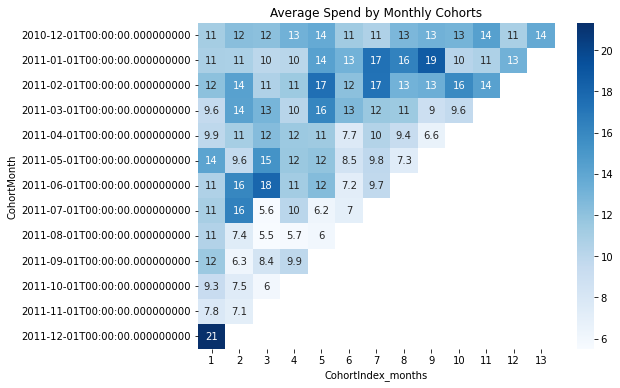

In [54]:
# Initialize an 8 by 6 inches plot figure
plt.figure(figsize=(8, 6))

# Add a title
plt.title('Average Spend by Monthly Cohorts')

# Create the heatmap
sns.heatmap(average_quantity, annot=True, cmap='Blues')
plt.show()